In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from bisect import bisect_left
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LeakyReLU, Dropout, BatchNormalization, Softmax
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
# Load data
data = pd.read_csv('final_matches_with_records.csv')
data = data.fillna(0)  # Assign back

player_name_columns = [col for col in data.columns if 'player' in col and 'name' in col]
tokenizer = Tokenizer(filters='', split='\t')

all_names = []
for col in player_name_columns:
    all_names.extend(data[col].fillna('').astype(str).values)

tokenizer.fit_on_texts(all_names)

for col in player_name_columns:
    data[col] = data[col].fillna('').astype(str).map(lambda name: tokenizer.texts_to_sequences([name])[0][0] if name else 0)


# Sort by date
data = data.sort_values(by='date')

feature_columns = ['home_away_indicator', 'real_api_id', 'other_team_id', 'real_winprob', 'tie_prob', 'other_winprob',
    'real_player_1_name', 'real_player_1_rating', 'real_player_1_potential', 'real_player_2_name', 'real_player_2_rating', 'real_player_2_potential',
    'real_player_3_name', 'real_player_3_rating', 'real_player_3_potential', 'real_player_4_name', 'real_player_4_rating', 'real_player_4_potential',
    'real_player_5_name', 'real_player_5_rating', 'real_player_5_potential', 'real_player_6_name', 'real_player_6_rating', 'real_player_6_potential',
    'real_player_7_name', 'real_player_7_rating', 'real_player_7_potential', 'real_player_8_name', 'real_player_8_rating', 'real_player_8_potential',
    'real_player_9_name', 'real_player_9_rating', 'real_player_9_potential', 'real_player_10_name', 'real_player_10_rating', 'real_player_10_potential',
    'real_player_11_name', 'real_player_11_rating', 'real_player_11_potential', 'other_player_1_name', 'other_player_1_rating', 'other_player_1_potential',
    'other_player_2_name', 'other_player_2_rating', 'other_player_2_potential', 'other_player_3_name', 'other_player_3_rating', 'other_player_3_potential',
    'other_player_4_name', 'other_player_4_rating', 'other_player_4_potential', 'other_player_5_name', 'other_player_5_rating', 'other_player_5_potential',
    'other_player_6_name', 'other_player_6_rating', 'other_player_6_potential', 'other_player_7_name', 'other_player_7_rating', 'other_player_7_potential',
    'other_player_8_name', 'other_player_8_rating', 'other_player_8_potential', 'other_player_9_name', 'other_player_9_rating', 'other_player_9_potential',
    'other_player_10_name', 'other_player_10_rating', 'other_player_10_potential', 'other_player_11_name', 'other_player_11_rating', 'other_player_11_potential',
    'real_wins', 'real_draws', 'real_losses', 'other_wins', 'other_draws', 'other_losses']

features = data[feature_columns]
label = to_categorical(data['result'], num_classes=3)

print("Features shape: ", features.shape)
print("Target shape: ", label.shape)

# Create sequences
sequence_length = 5
X_sequences = []
y_labels = []

for i in range(len(features) - sequence_length):
    sequence = features.iloc[i:i + sequence_length].values
    y = label[i + sequence_length]
    X_sequences.append(sequence)
    y_labels.append(y)

X = np.array(X_sequences)
y = np.array(y_labels)

print("X shape (samples, timesteps, features):", X.shape)
print("y shape (samples, 3):", y.shape)


Features shape:  (304, 78)
Target shape:  (304, 3)
X shape (samples, timesteps, features): (299, 5, 78)
y shape (samples, 3): (299, 3)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (239, 5, 78) (239, 3)
Test shape: (60, 5, 78) (60, 3)


In [11]:
# Flatten sequences for scaling
num_train, timesteps, num_features = X_train.shape
num_test = X_test.shape[0]

X_train_flat = X_train.reshape(-1, num_features)
X_test_flat = X_test.reshape(-1, num_features)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Reshape back to (samples, timesteps, features)
X_train = X_train_scaled.reshape(num_train, timesteps, num_features)
X_test = X_test_scaled.reshape(num_test, timesteps, num_features)


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
model = Sequential([
    GRU(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100


C:\Users\benja\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.4435 - loss: 1.0296 - val_accuracy: 0.6875 - val_loss: 0.9396
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6811 - loss: 0.8111 - val_accuracy: 0.7500 - val_loss: 0.8628
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6641 - loss: 0.7987 - val_accuracy: 0.7500 - val_loss: 0.8238
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7373 - loss: 0.7138 - val_accuracy: 0.7500 - val_loss: 0.8163
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7839 - loss: 0.6533 - val_accuracy: 0.7708 - val_loss: 0.8206
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7803 - loss: 0.5958 - val_accuracy: 0.7708 - val_loss: 0.8276
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7620 - loss: 0.5942 - val_accuracy: 0.7708 - val_loss: 0.8318
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7989 - loss: 0.4986 - val_accuracy: 0.7708 - val_los

In [14]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.6833


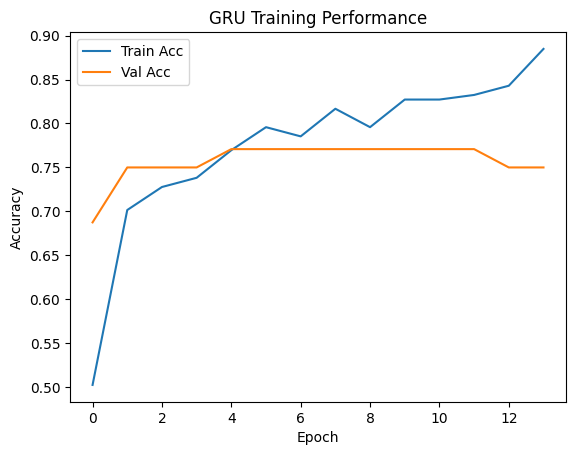

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('GRU Training Performance')
plt.legend()
plt.show()
